In [1]:
from typing import List

from oop_functions.experiment_helper import ExperimentDataHelper1
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier

import itertools


In [2]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)
missing_df = pd.read_csv('./missing_features/combined_missing.csv', index_col=0)

In [3]:
screen_data_cols = ['study_yr', 'detl_p', 'detr_p', 'lvol_p', 'rvol_p', 'lvol_q', 'rvol_q',
       'lantero_p', 'lantero_q', 'llong_p', 'llong_q', 'ltran_p', 'ltran_q',
       'rantero_p', 'rantero_q', 'rlong_p', 'rlong_q', 'rtran_p', 'rtran_q',
       'tvu_ref', 'phycons', 'tvu_result', 'ca125_result', 'ovar_result',
       'ovcyst_solidr', 'ovcyst_outliner', 'ovcyst_solidl', 'ovcyst_outlinel',
       'ovcyst_solid', 'ovcyst_outline', 'ovcyst_diamr', 'ovcyst_diaml',
       'ovcyst_diam', 'ovcyst_volr', 'ovcyst_voll', 'ovcyst_vol',
       'ovcyst_morphr', 'ovcyst_morphl', 'ovcyst_morph', 'ovcyst_sumr',
       'ovcyst_suml', 'ovcyst_sum', 'ovary_diam', 'ovary_diamr', 'ovary_diaml',
       'ovary_volr', 'ovary_voll', 'ovary_vol', 'visl', 'visr', 'visboth',
       'viseith', 'numcystl', 'numcystr', 'numcyst', 'plco_id', 'ovar_days']

screen_abnorm_data_cols = ['study_yr', 'solid', 'sepst', 'cyst', 'cystw', 'echo', 'maxdi', 'volum',
       'plco_id']

screened_cols = screen_data_cols + screen_abnorm_data_cols + ['ca125ii', 'ca125_result']

## Merging Datasets

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

https://stackoverflow.com/questions/62819569/how-to-return-the-features-that-used-in-decision-tree-that-created-by-decisiontr

`TODO:` Run model purely on family history variables vs purely on screen variables. 

`TODO:` turn all of this into OOP programming

`TODO:` include the level of missingness for a particular features of a tree in order of usage.

`TODO:` divide them as FP and FN?

`TODO:` only keep columns with more than 1 unique value? 

`TODO:` make spreadsheet with model performance for 1,3,5,10 years. Print out trees, top 5 features. Send models

`TODO:` try SVM or ML models

`TODO:` At what point they were misclassified (e.g. at what point they diverge compared to the similar point with different prediction.) Look at the nearest neightbors with different neightbors. 

In [4]:
def isin_filter(df: pd.DataFrame, col: str, values: List):
    return df[df[col].isin(values)]

# filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
# TODO: finish this one
differentiate_confusion_matrix_over = {
    'was_screened': [
        ([0], lambda df: isin_filter(df, 'was_screened', [0])), 
        ([1], lambda df: isin_filter(df, 'was_screened', [1]))
    ], 
    'ovar_histtype': [[2], [2, 4, 6, 8, 9, 31]]
}

In [5]:
list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))

[('was_screened', ([0], <function __main__.<lambda>(df)>)),
 ('was_screened', ([1], <function __main__.<lambda>(df)>)),
 ('ovar_histtype', [2]),
 ('ovar_histtype', [2, 4, 6, 8, 9, 31])]

In [ ]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'entropy', n_estimators= 200),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}
cv_analytics_utils = {}
years = [1]
num_folds=10
test_n_folds=10
for classifier_name, classifier in classifiers.items():
    for year in years:
        label = f'cancer_in_next_{year}_years'
        experiment_data_helper = ExperimentDataHelper1(processed_data, label, ['cancer_'])
        experiment_runner = ExperimentRunner(classifier, experiment_data_helper, missing_df, num_folds=num_folds, test_n_folds=test_n_folds)
        cv_analytics_util = experiment_runner.run_experiment()
        cv_analytics_utils[f'{classifier_name}_for_{label}'] = cv_analytics_util


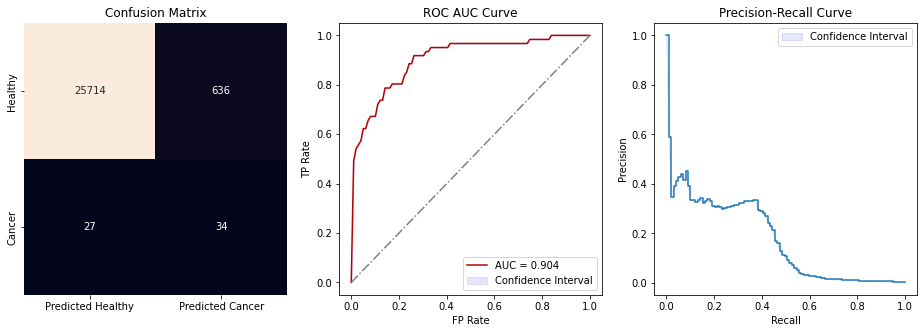

In [15]:
cv_analytics_util.display_graph()

In [7]:
X_test_mismatch = cv_analytics_util.analytics_utils[0].get_high_confidence_errors()

In [8]:
false_negatives = pd.concat(np.array(X_test_mismatch)[:, 0])
false_negatives = false_negatives[false_negatives['cancer_in_next_1_years_prob'] < 0.14151879]
print_df(false_negatives)

+--------+-------+------------+-------------+-------+---------+-------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+----------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+----------+------------+------------+-------------+---------+-----------+---------------------+-----------+---------+---------+----------+----------+--------------+--------------+--------+--------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+--------+----------+-----------------------+-------------+-------------+---------+---------------------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------------+-----------+----------+-----------+---------------------+---

In [9]:
len(false_negatives)

12

In [10]:
print_df(pd.concat(X_test_mismatch[1][:2]))

+--------+-------+------------+-------------+-------+---------+-------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+----------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+----------+------------+------------+-------------+---------+-----------+---------------------+-----------+---------+---------+----------+----------+--------------+--------------+--------+--------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+--------+----------+-----------------------+-------------+-------------+---------+---------------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-----------------+-----------+---------+-----------+---------------------+-----

In [11]:
# drop col if the feature value of patient that was misclassified does not appear in the list of feature values of patients that were classified
df = pd.concat(X_test_mismatch[1][:2])
for col in df.columns:
    if df[col].iloc[0] in df[col].iloc[list(range(1, 6))].to_list():
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)

+--------+----------+----------+------------+------------+----------+------------+-------------+--------------+----------+-----------+------------+-----------+-----------+--------------+---------------+-------------+--------------+---------------+--------------+-----------+-----------+----------+--------------+------------+--------------------------+-------------------------------+-------------------------------+------------+
|        |   bmi_20 |   bmi_50 |   bmi_curc |   bmi_curr |   center |   cig_stop |   cig_years |   diabetes_f |   educat |   fchilda |   height_f |   lmenstr |   occupat |   ovary_diam |   ovary_diamr |   ovary_vol |   ovary_volr |   ovcyst_diam |   pack_years |   rlong_p |   rtran_p |   rvol_p |   weight20_f |   weight_f |   cancer_in_next_1_years |   cancer_in_next_1_years_pred |   cancer_in_next_1_years_prob |   distance |
|--------+----------+----------+------------+------------+----------+------------+-------------+--------------+----------+-----------+------

In [12]:

df = pd.concat(X_test_mismatch[4][:2])
for col in df.columns:
    if len(df[col].unique()) <= 2:
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)
print_df(summary)

+--------+-------+------------+---------+----------+----------+------------+----------+-----------------+----------+----------+-----------+------------+----------+-------------+---------+-----------+-----------+----------+--------------+---------------+---------------+-------------+--------------+--------------+---------------+---------------+--------------+--------------+---------+---------+-------------+-----------+-----------+----------+-----------+---------+--------------+--------------+------------+------------+
|        |   age |   agelevel |   asppd |   bmi_20 |   bmi_50 |   bmi_curr |   bq_age |   breast_fh_age |   center |   educat |   fchilda |   height_f |   ibuppd |   lantero_p |   livec |   llong_p |   ltran_p |   lvol_p |   ovary_diam |   ovary_diaml |   ovary_diamr |   ovary_vol |   ovary_voll |   ovary_volr |   ovcyst_diam |   ovcyst_volr |   ph_any_muq |   ph_any_sqx |   prega |   pregc |   rantero_p |   rlong_p |   rtran_p |   rvol_p |   sisters |   thorm |   weight20